In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose
from keras.preprocessing.image import img_to_array, load_img
from keras.models import Sequential, Model
from keras.optimizers import Adam

import os

C:\Users\akash\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# GAN Class

In [200]:
class MNISTGAN:
    def __init__(self, width = 96, height = 96, channels = 3):
        # Setting Width, Height, Channels for each input image.
        self.width = width
        self.height = height
        self.channels = channels
        # Defining input shape.
        self.shape = (self.width, self.height, self.channels)
        # Setting up the optimizer.
        self.optimizer = Adam(0.0002, 0.5)
        # Creating & compiling the discriminator.
        self.discriminator = self.make_discriminator()
        self.discriminator.compile(loss = 'binary_crossentropy', optimizer = self.optimizer, metrics = ['accuracy'])
        # Creating the generator.
        self.generator = self.make_generator()
        # Generator takes noise as input and generates images.
        z = Input(shape=(100,))
        img = self.generator(z)
        # Discriminator is not allowed to update itself in the combined model.
        self.discriminator.trainable = False
        # Discriminator takes generated images as input and determines the validity.
        valid = self.discriminator(img)
        # Creating & compiling the GAN.
        self.combined = Model(z, valid)
        self.combined.compile(loss = 'binary_crossentropy', optimizer = self.optimizer)
        self.combined.summary()
        # Creating variables to hold overall loss.
        self.overall_discriminator_loss, self.overall_generator_loss = [], []
    
    def make_generator(self):
        # dropout = 0.4
        depth = 128
        dimension = self.height // 4
        model = Sequential()
        
        model.add(Dense(dimension * dimension * depth, input_dim = 100, activation='relu'))
        model.add(Reshape((dimension, dimension, depth)))
        
        model.add(UpSampling2D())
        model.add(Conv2D(int(depth), kernel_size = 3, padding = 'same'))
        model.add(BatchNormalization(momentum = 0.8))
        model.add(Activation('relu'))
        
        model.add(UpSampling2D())
        model.add(Conv2D(int(depth / 2), kernel_size = 3, padding = 'same'))
        model.add(BatchNormalization(momentum = 0.8))
        model.add(Activation('relu'))
        
        model.add(Conv2D(self.channels, kernel_size = 3, padding = 'same'))
        model.add(Activation('tanh'))
        
        model.summary()
        
        noise = Input(shape=(100,))
        img = model(noise)
        
        return Model(noise, img)
        
    def make_discriminator(self):
        dropout = 0.25
        depth = 32
        model = Sequential()
        
        model.add(Conv2D(depth * 1, kernel_size = 3, strides = 2, input_shape = self.shape, padding = 'same'))
        model.add(LeakyReLU(alpha = 0.2))
        model.add(Dropout(dropout))
        
        model.add(Conv2D(depth * 2, kernel_size = 3, strides = 2, padding = 'same'))
        model.add(ZeroPadding2D(padding = ((0, 1), (0, 1))))
        model.add(BatchNormalization(momentum = 0.8))
        model.add(LeakyReLU(alpha = 0.2))
        model.add(Dropout(dropout))
        
        model.add(Conv2D(depth * 4, kernel_size = 3, strides = 2, padding = 'same'))
        model.add(BatchNormalization(momentum = 0.8))
        model.add(LeakyReLU(alpha = 0.2))
        model.add(Dropout(dropout))
        
        model.add(Conv2D(depth * 8, kernel_size = 3, strides = 1, padding = 'same'))
        model.add(BatchNormalization(momentum = 0.8))
        model.add(LeakyReLU(alpha = 0.2))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        
        model.summary()
        
        img = Input(shape=self.shape)
        validity = model(img)
        
        return Model(img, validity)
    
    def train(self, training_data, epochs=100, batch_size=32, save_interval=50):
        
        # Rescale data -1 to +1
        training_data = (training_data / 127.5) - 1
        training_data = np.expand_dims(training_data, axis=3)
        
        # Adversarial Ground Truths
        valid = np.ones((batch_size, 1)) 
        fake = np.zeros((batch_size, 1))
        
        for epoch in range(epochs):
            
            # -------------------
            # Train Discriminator
            # -------------------
            
            # Select a random batch of images.
            index = np.random.randint(0, training_data.shape[0], batch_size)
            real_images = training_data[index]
            
            # Sample noise and generate a batch of new images.
            noise = np.random.normal(0, 1, (batch_size, 100))
            fake_images = self.generator.predict(noise)
            
            # Train the discriminator (real classified as ones and generated as zeros)
            discriminator_loss_real = self.discriminator.train_on_batch(real_images, valid)
            discriminator_loss_fake = self.discriminator.train_on_batch(fake_images, fake)
            discriminator_loss = 0.5 * np.add(discriminator_loss_real, discriminator_loss_fake)
            self.overall_discriminator_loss.append(discriminator_loss[0])
            
            # ---------------
            # Train Generator
            # ---------------
            
            # Train the generator (wants discriminator to mistake images as real)
            generator_loss = self.combined.train_on_batch(noise, valid)
            self.overall_generator_loss.append(generator_loss)
            
            # Plot the progress.
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, discriminator_loss[0], 100 * discriminator_loss[1], generator_loss))
            
            # If at save interval => Save generated image samples
            if epoch % save_interval == 0 or epoch == epochs - 1:
                self.save_images(epoch)
                self.save_model_weights(epoch)
        
        self.plot_loss()
                
    def save_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, 100))
        generated_images = self.generator.predict(noise)

        # Rescale images 0 - 1
        generated_images = ((generated_images * 0.5) + 0.5)
        
        fig, axis = plt.subplots(r, c)
        count = 0
        for i in range(r):
            for j in range(c):
                axis[i, j].imshow(generated_images[count, :, :, 0])
                axis[i, j].axis('off')
                count += 1
        plt.savefig("output/mnistGAN_%d.png" % epoch, dpi=300)
        plt.close()

    def save_model_weights(self, epoch):
        self.generator.save_weights('weights/epoch-' + str(epoch) + '-generator.h5')
        self.discriminator.save_weights('weights/epoch-' + str(epoch) + '-discriminator.h5')
        self.combined.save_weights('weights/epoch-' + str(epoch) + '-combined.h5')
        
    def plot_loss(self):
        plt.figure(figsize=(10, 8), dpi=300)
        plt.plot(self.overall_discriminator_loss, label="Discriminator Loss")
        plt.plot(self.overall_generator_loss, label="Generator Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.savefig('output/gan_loss.png')

# Preprocessing

In [201]:
data = []
for _, _, files in os.walk(os.path.join(os.getcwd(), 'gen5')):
    for file in files:
        file_path = os.path.join(os.getcwd(), 'gen5', file)
        image = load_img(file_path, target_size=(64, 64))
        image = img_to_array(image)
        data.append(image)

In [202]:
data = np.array(data)

In [203]:
data.shape

(1342, 64, 64, 3)

# Training

In [196]:
from keras.datasets import mnist

In [197]:
(x_train, _), (_, _) = mnist.load_data()

In [198]:
mnistGAN = MNISTGAN(28, 28, 1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_166 (Conv2D)          (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_211 (LeakyReLU)  (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_211 (Dropout)        (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_167 (Conv2D)          (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_183 (Bat (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_212 (LeakyReLU)  (None, 8, 8, 64)          0         
__________

C:\Users\akash\Anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.823290, acc.: 50.00%] [G loss: 0.729213]
1 [D loss: 0.488142, acc.: 76.56%] [G loss: 1.197270]
2 [D loss: 0.301455, acc.: 92.19%] [G loss: 1.630764]
3 [D loss: 0.161314, acc.: 98.44%] [G loss: 1.894971]
4 [D loss: 0.185239, acc.: 93.75%] [G loss: 1.642905]
5 [D loss: 0.199703, acc.: 93.75%] [G loss: 1.301887]
6 [D loss: 0.157967, acc.: 95.31%] [G loss: 1.716910]
7 [D loss: 0.437806, acc.: 78.12%] [G loss: 2.344477]
8 [D loss: 0.654662, acc.: 62.50%] [G loss: 2.772100]
9 [D loss: 0.887352, acc.: 51.56%] [G loss: 2.756812]
10 [D loss: 0.761735, acc.: 56.25%] [G loss: 3.175337]
11 [D loss: 0.957752, acc.: 50.00%] [G loss: 2.159000]
12 [D loss: 0.518472, acc.: 76.56%] [G loss: 2.236382]
13 [D loss: 0.559906, acc.: 65.62%] [G loss: 2.169430]
14 [D loss: 0.516918, acc.: 75.00%] [G loss: 1.608003]
15 [D loss: 0.371253, acc.: 84.38%] [G loss: 1.489863]
16 [D loss: 0.335357, acc.: 81.25%] [G loss: 0.704556]
17 [D loss: 0.222244, acc.: 92.19%] [G loss: 0.383913]
18 [D loss: 0.205408

149 [D loss: 0.902014, acc.: 48.44%] [G loss: 1.023786]
150 [D loss: 0.701726, acc.: 60.94%] [G loss: 1.162191]
151 [D loss: 0.841455, acc.: 40.62%] [G loss: 1.154264]
152 [D loss: 0.894151, acc.: 40.62%] [G loss: 1.109014]
153 [D loss: 0.729120, acc.: 54.69%] [G loss: 1.348753]
154 [D loss: 0.993132, acc.: 43.75%] [G loss: 1.159968]
155 [D loss: 0.850162, acc.: 53.12%] [G loss: 1.261077]
156 [D loss: 0.862467, acc.: 48.44%] [G loss: 1.082538]
157 [D loss: 0.867390, acc.: 51.56%] [G loss: 0.952441]
158 [D loss: 0.919666, acc.: 45.31%] [G loss: 1.004155]
159 [D loss: 0.826346, acc.: 56.25%] [G loss: 1.300213]
160 [D loss: 0.871918, acc.: 48.44%] [G loss: 0.951793]
161 [D loss: 0.832133, acc.: 48.44%] [G loss: 1.045993]
162 [D loss: 0.789003, acc.: 48.44%] [G loss: 1.342121]
163 [D loss: 0.715899, acc.: 57.81%] [G loss: 1.049514]
164 [D loss: 0.642703, acc.: 65.62%] [G loss: 1.021456]
165 [D loss: 0.717932, acc.: 51.56%] [G loss: 1.195248]
166 [D loss: 0.847827, acc.: 40.62%] [G loss: 1.

296 [D loss: 0.704071, acc.: 56.25%] [G loss: 1.105027]
297 [D loss: 0.804217, acc.: 43.75%] [G loss: 1.213187]
298 [D loss: 0.722399, acc.: 57.81%] [G loss: 0.931059]
299 [D loss: 0.759048, acc.: 53.12%] [G loss: 1.218822]
300 [D loss: 0.794393, acc.: 48.44%] [G loss: 1.269809]
301 [D loss: 0.847406, acc.: 51.56%] [G loss: 1.201968]
302 [D loss: 0.719587, acc.: 57.81%] [G loss: 1.195088]
303 [D loss: 0.758717, acc.: 46.88%] [G loss: 1.215769]
304 [D loss: 0.772444, acc.: 53.12%] [G loss: 1.215592]
305 [D loss: 0.728601, acc.: 54.69%] [G loss: 1.221152]
306 [D loss: 0.808027, acc.: 45.31%] [G loss: 0.994766]
307 [D loss: 0.653953, acc.: 62.50%] [G loss: 1.142834]
308 [D loss: 0.736229, acc.: 54.69%] [G loss: 1.368787]
309 [D loss: 0.694190, acc.: 57.81%] [G loss: 1.016295]
310 [D loss: 0.741712, acc.: 51.56%] [G loss: 1.315136]
311 [D loss: 0.822407, acc.: 48.44%] [G loss: 1.274156]
312 [D loss: 0.784562, acc.: 53.12%] [G loss: 1.195175]
313 [D loss: 0.718270, acc.: 54.69%] [G loss: 1.

445 [D loss: 0.837951, acc.: 46.88%] [G loss: 0.889914]
446 [D loss: 0.675308, acc.: 59.38%] [G loss: 1.085439]
447 [D loss: 0.713194, acc.: 53.12%] [G loss: 1.195513]
448 [D loss: 0.701090, acc.: 59.38%] [G loss: 1.259105]
449 [D loss: 0.832513, acc.: 51.56%] [G loss: 1.126843]
450 [D loss: 0.796087, acc.: 42.19%] [G loss: 1.016298]
451 [D loss: 0.639991, acc.: 62.50%] [G loss: 1.016924]
452 [D loss: 0.780721, acc.: 51.56%] [G loss: 1.084487]
453 [D loss: 0.747228, acc.: 56.25%] [G loss: 1.113337]
454 [D loss: 0.774290, acc.: 50.00%] [G loss: 0.985030]
455 [D loss: 0.786365, acc.: 54.69%] [G loss: 0.977337]
456 [D loss: 0.654073, acc.: 65.62%] [G loss: 1.000072]
457 [D loss: 0.682325, acc.: 57.81%] [G loss: 1.249581]
458 [D loss: 0.782530, acc.: 51.56%] [G loss: 0.956941]
459 [D loss: 0.658920, acc.: 65.62%] [G loss: 1.093559]
460 [D loss: 0.784066, acc.: 51.56%] [G loss: 1.021438]
461 [D loss: 0.756671, acc.: 56.25%] [G loss: 0.959636]
462 [D loss: 0.689694, acc.: 51.56%] [G loss: 1.

593 [D loss: 0.634070, acc.: 67.19%] [G loss: 1.087635]
594 [D loss: 0.741362, acc.: 54.69%] [G loss: 1.055249]
595 [D loss: 0.833226, acc.: 45.31%] [G loss: 1.102258]
596 [D loss: 0.699206, acc.: 51.56%] [G loss: 1.410214]
597 [D loss: 0.760877, acc.: 50.00%] [G loss: 1.028514]
598 [D loss: 0.773913, acc.: 51.56%] [G loss: 1.266297]
599 [D loss: 0.728080, acc.: 59.38%] [G loss: 1.103637]
600 [D loss: 0.716932, acc.: 54.69%] [G loss: 1.092947]
601 [D loss: 0.729854, acc.: 57.81%] [G loss: 1.142767]
602 [D loss: 0.882870, acc.: 45.31%] [G loss: 0.910062]
603 [D loss: 0.732687, acc.: 54.69%] [G loss: 0.898854]
604 [D loss: 0.675522, acc.: 60.94%] [G loss: 0.984678]
605 [D loss: 0.700512, acc.: 59.38%] [G loss: 1.126505]
606 [D loss: 0.656693, acc.: 71.88%] [G loss: 1.221874]
607 [D loss: 0.542513, acc.: 68.75%] [G loss: 1.104015]
608 [D loss: 0.805840, acc.: 45.31%] [G loss: 0.960847]
609 [D loss: 0.664221, acc.: 60.94%] [G loss: 1.167660]
610 [D loss: 0.716679, acc.: 51.56%] [G loss: 1.

740 [D loss: 0.687572, acc.: 59.38%] [G loss: 1.129535]
741 [D loss: 0.684443, acc.: 54.69%] [G loss: 1.130130]
742 [D loss: 0.741777, acc.: 56.25%] [G loss: 0.879202]
743 [D loss: 0.713555, acc.: 53.12%] [G loss: 0.943679]
744 [D loss: 0.716226, acc.: 46.88%] [G loss: 1.014955]
745 [D loss: 0.761950, acc.: 50.00%] [G loss: 0.980603]
746 [D loss: 0.695189, acc.: 65.62%] [G loss: 0.956111]
747 [D loss: 0.682726, acc.: 65.62%] [G loss: 0.970629]
748 [D loss: 0.639858, acc.: 62.50%] [G loss: 1.194497]
749 [D loss: 0.851847, acc.: 42.19%] [G loss: 1.103668]
750 [D loss: 0.759311, acc.: 45.31%] [G loss: 0.907680]
751 [D loss: 0.749033, acc.: 54.69%] [G loss: 0.956113]
752 [D loss: 0.739723, acc.: 51.56%] [G loss: 1.080544]
753 [D loss: 0.756459, acc.: 53.12%] [G loss: 1.144307]
754 [D loss: 0.732917, acc.: 51.56%] [G loss: 1.055517]
755 [D loss: 0.699668, acc.: 54.69%] [G loss: 1.016589]
756 [D loss: 0.778130, acc.: 46.88%] [G loss: 1.052438]
757 [D loss: 0.769469, acc.: 48.44%] [G loss: 0.

887 [D loss: 0.756474, acc.: 45.31%] [G loss: 1.162502]
888 [D loss: 0.702670, acc.: 51.56%] [G loss: 0.937192]
889 [D loss: 0.750158, acc.: 57.81%] [G loss: 1.030185]
890 [D loss: 0.662505, acc.: 53.12%] [G loss: 0.948151]
891 [D loss: 0.724511, acc.: 50.00%] [G loss: 1.063074]
892 [D loss: 0.653843, acc.: 62.50%] [G loss: 0.869776]
893 [D loss: 0.801935, acc.: 50.00%] [G loss: 1.074921]
894 [D loss: 0.717389, acc.: 54.69%] [G loss: 0.902862]
895 [D loss: 0.759778, acc.: 54.69%] [G loss: 1.053239]
896 [D loss: 0.829103, acc.: 45.31%] [G loss: 0.921790]
897 [D loss: 0.705176, acc.: 53.12%] [G loss: 1.233585]
898 [D loss: 0.688343, acc.: 57.81%] [G loss: 1.069755]
899 [D loss: 0.742222, acc.: 53.12%] [G loss: 1.116064]
900 [D loss: 0.662538, acc.: 60.94%] [G loss: 0.892753]
901 [D loss: 0.709264, acc.: 53.12%] [G loss: 1.022110]
902 [D loss: 0.698202, acc.: 57.81%] [G loss: 0.918652]
903 [D loss: 0.705225, acc.: 57.81%] [G loss: 1.028083]
904 [D loss: 0.710419, acc.: 53.12%] [G loss: 0.

1034 [D loss: 0.729826, acc.: 53.12%] [G loss: 1.087397]
1035 [D loss: 0.868421, acc.: 40.62%] [G loss: 0.994253]
1036 [D loss: 0.793065, acc.: 42.19%] [G loss: 0.920067]
1037 [D loss: 0.663038, acc.: 62.50%] [G loss: 0.912427]
1038 [D loss: 0.775469, acc.: 46.88%] [G loss: 1.040211]
1039 [D loss: 0.689968, acc.: 59.38%] [G loss: 1.067179]
1040 [D loss: 0.735510, acc.: 43.75%] [G loss: 1.033186]
1041 [D loss: 0.719424, acc.: 60.94%] [G loss: 0.972014]
1042 [D loss: 0.737175, acc.: 56.25%] [G loss: 1.222063]
1043 [D loss: 0.657884, acc.: 60.94%] [G loss: 1.021970]
1044 [D loss: 0.747138, acc.: 51.56%] [G loss: 1.018425]
1045 [D loss: 0.869820, acc.: 39.06%] [G loss: 0.975051]
1046 [D loss: 0.764444, acc.: 46.88%] [G loss: 1.059459]
1047 [D loss: 0.703032, acc.: 45.31%] [G loss: 1.109073]
1048 [D loss: 0.740933, acc.: 48.44%] [G loss: 1.025630]
1049 [D loss: 0.697879, acc.: 50.00%] [G loss: 1.002597]
1050 [D loss: 0.843552, acc.: 43.75%] [G loss: 0.847197]
1051 [D loss: 0.736251, acc.: 5

1178 [D loss: 0.684755, acc.: 57.81%] [G loss: 1.099347]
1179 [D loss: 0.680694, acc.: 64.06%] [G loss: 0.959486]
1180 [D loss: 0.734834, acc.: 51.56%] [G loss: 1.058239]
1181 [D loss: 0.741577, acc.: 60.94%] [G loss: 1.003748]
1182 [D loss: 0.729217, acc.: 51.56%] [G loss: 0.931140]
1183 [D loss: 0.653080, acc.: 59.38%] [G loss: 1.161517]
1184 [D loss: 0.667411, acc.: 60.94%] [G loss: 1.195869]
1185 [D loss: 0.735484, acc.: 51.56%] [G loss: 0.876893]
1186 [D loss: 0.691185, acc.: 57.81%] [G loss: 1.151698]
1187 [D loss: 0.650108, acc.: 60.94%] [G loss: 1.106753]
1188 [D loss: 0.691067, acc.: 56.25%] [G loss: 1.041235]
1189 [D loss: 0.682685, acc.: 56.25%] [G loss: 0.917857]
1190 [D loss: 0.716333, acc.: 51.56%] [G loss: 1.025849]
1191 [D loss: 0.721457, acc.: 59.38%] [G loss: 1.069975]
1192 [D loss: 0.787262, acc.: 42.19%] [G loss: 1.039118]
1193 [D loss: 0.656461, acc.: 57.81%] [G loss: 1.040048]
1194 [D loss: 0.705853, acc.: 60.94%] [G loss: 1.123210]
1195 [D loss: 0.754988, acc.: 5

1322 [D loss: 0.721774, acc.: 59.38%] [G loss: 0.926048]
1323 [D loss: 0.712665, acc.: 54.69%] [G loss: 1.049701]
1324 [D loss: 0.744907, acc.: 43.75%] [G loss: 0.924730]
1325 [D loss: 0.790855, acc.: 50.00%] [G loss: 1.065682]
1326 [D loss: 0.736877, acc.: 48.44%] [G loss: 0.977188]
1327 [D loss: 0.787541, acc.: 48.44%] [G loss: 1.043504]
1328 [D loss: 0.702935, acc.: 56.25%] [G loss: 0.971819]
1329 [D loss: 0.723775, acc.: 53.12%] [G loss: 1.084291]
1330 [D loss: 0.735838, acc.: 53.12%] [G loss: 0.978200]
1331 [D loss: 0.719681, acc.: 50.00%] [G loss: 0.992396]
1332 [D loss: 0.702853, acc.: 57.81%] [G loss: 1.199236]
1333 [D loss: 0.684156, acc.: 57.81%] [G loss: 0.919859]
1334 [D loss: 0.723742, acc.: 51.56%] [G loss: 0.986102]
1335 [D loss: 0.660747, acc.: 60.94%] [G loss: 0.920967]
1336 [D loss: 0.718477, acc.: 53.12%] [G loss: 1.105756]
1337 [D loss: 0.714919, acc.: 45.31%] [G loss: 0.928182]
1338 [D loss: 0.635358, acc.: 67.19%] [G loss: 1.164087]
1339 [D loss: 0.782420, acc.: 4

1466 [D loss: 0.660273, acc.: 57.81%] [G loss: 1.149116]
1467 [D loss: 0.761588, acc.: 53.12%] [G loss: 0.899164]
1468 [D loss: 0.671576, acc.: 57.81%] [G loss: 0.906956]
1469 [D loss: 0.692950, acc.: 56.25%] [G loss: 1.086291]
1470 [D loss: 0.673783, acc.: 60.94%] [G loss: 1.010101]
1471 [D loss: 0.638400, acc.: 70.31%] [G loss: 1.047453]
1472 [D loss: 0.781707, acc.: 42.19%] [G loss: 0.958807]
1473 [D loss: 0.735370, acc.: 50.00%] [G loss: 1.008474]
1474 [D loss: 0.664141, acc.: 60.94%] [G loss: 0.919764]
1475 [D loss: 0.665352, acc.: 57.81%] [G loss: 1.019452]
1476 [D loss: 0.667519, acc.: 64.06%] [G loss: 1.025891]
1477 [D loss: 0.731495, acc.: 53.12%] [G loss: 1.063296]
1478 [D loss: 0.610228, acc.: 70.31%] [G loss: 1.160807]
1479 [D loss: 0.736642, acc.: 57.81%] [G loss: 0.926899]
1480 [D loss: 0.764319, acc.: 53.12%] [G loss: 0.963264]
1481 [D loss: 0.679531, acc.: 60.94%] [G loss: 0.965231]
1482 [D loss: 0.725347, acc.: 60.94%] [G loss: 1.014088]
1483 [D loss: 0.724167, acc.: 5

1610 [D loss: 0.753013, acc.: 51.56%] [G loss: 1.004270]
1611 [D loss: 0.662844, acc.: 59.38%] [G loss: 0.882365]
1612 [D loss: 0.705135, acc.: 54.69%] [G loss: 1.239929]
1613 [D loss: 0.660786, acc.: 62.50%] [G loss: 0.919626]
1614 [D loss: 0.635364, acc.: 59.38%] [G loss: 1.058017]
1615 [D loss: 0.708597, acc.: 51.56%] [G loss: 0.995041]
1616 [D loss: 0.781324, acc.: 43.75%] [G loss: 0.991855]
1617 [D loss: 0.712813, acc.: 53.12%] [G loss: 0.926320]
1618 [D loss: 0.719178, acc.: 48.44%] [G loss: 0.907412]
1619 [D loss: 0.681395, acc.: 60.94%] [G loss: 0.931677]
1620 [D loss: 0.547790, acc.: 73.44%] [G loss: 1.191980]
1621 [D loss: 0.746592, acc.: 54.69%] [G loss: 1.046624]
1622 [D loss: 0.657490, acc.: 60.94%] [G loss: 1.122257]
1623 [D loss: 0.644020, acc.: 62.50%] [G loss: 1.006849]
1624 [D loss: 0.736305, acc.: 46.88%] [G loss: 0.872700]
1625 [D loss: 0.637653, acc.: 62.50%] [G loss: 1.040537]
1626 [D loss: 0.796400, acc.: 46.88%] [G loss: 1.017559]
1627 [D loss: 0.652616, acc.: 6

1754 [D loss: 0.611695, acc.: 75.00%] [G loss: 1.057051]
1755 [D loss: 0.691945, acc.: 54.69%] [G loss: 1.151646]
1756 [D loss: 0.719735, acc.: 51.56%] [G loss: 0.932550]
1757 [D loss: 0.740966, acc.: 50.00%] [G loss: 0.921962]
1758 [D loss: 0.692053, acc.: 53.12%] [G loss: 0.782576]
1759 [D loss: 0.722578, acc.: 54.69%] [G loss: 0.976541]
1760 [D loss: 0.603195, acc.: 65.62%] [G loss: 1.056610]
1761 [D loss: 0.715675, acc.: 53.12%] [G loss: 0.940604]
1762 [D loss: 0.649348, acc.: 64.06%] [G loss: 0.955219]
1763 [D loss: 0.679397, acc.: 60.94%] [G loss: 1.227529]
1764 [D loss: 0.766181, acc.: 45.31%] [G loss: 1.080247]
1765 [D loss: 0.723512, acc.: 50.00%] [G loss: 1.012548]
1766 [D loss: 0.725350, acc.: 59.38%] [G loss: 0.836800]
1767 [D loss: 0.754669, acc.: 42.19%] [G loss: 0.977515]
1768 [D loss: 0.614048, acc.: 64.06%] [G loss: 0.917055]
1769 [D loss: 0.707998, acc.: 51.56%] [G loss: 0.952186]
1770 [D loss: 0.619282, acc.: 57.81%] [G loss: 1.047074]
1771 [D loss: 0.684582, acc.: 6

1900 [D loss: 0.642180, acc.: 65.62%] [G loss: 1.063308]
1901 [D loss: 0.777218, acc.: 51.56%] [G loss: 0.967492]
1902 [D loss: 0.758098, acc.: 46.88%] [G loss: 0.934964]
1903 [D loss: 0.693376, acc.: 48.44%] [G loss: 1.105736]
1904 [D loss: 0.613908, acc.: 67.19%] [G loss: 1.016537]
1905 [D loss: 0.782863, acc.: 45.31%] [G loss: 0.944521]
1906 [D loss: 0.725867, acc.: 50.00%] [G loss: 0.973440]
1907 [D loss: 0.707562, acc.: 54.69%] [G loss: 1.039823]
1908 [D loss: 0.657461, acc.: 60.94%] [G loss: 1.036517]
1909 [D loss: 0.628293, acc.: 62.50%] [G loss: 1.038910]
1910 [D loss: 0.713418, acc.: 48.44%] [G loss: 0.982063]
1911 [D loss: 0.687256, acc.: 54.69%] [G loss: 1.061395]
1912 [D loss: 0.721707, acc.: 51.56%] [G loss: 0.949344]
1913 [D loss: 0.597871, acc.: 68.75%] [G loss: 1.118695]
1914 [D loss: 0.757890, acc.: 50.00%] [G loss: 1.041937]
1915 [D loss: 0.643135, acc.: 56.25%] [G loss: 0.979547]
1916 [D loss: 0.671455, acc.: 59.38%] [G loss: 1.056973]
1917 [D loss: 0.658526, acc.: 6

2045 [D loss: 0.800540, acc.: 46.88%] [G loss: 0.927825]
2046 [D loss: 0.718567, acc.: 53.12%] [G loss: 0.869202]
2047 [D loss: 0.678381, acc.: 60.94%] [G loss: 0.861678]
2048 [D loss: 0.616412, acc.: 64.06%] [G loss: 0.966256]
2049 [D loss: 0.658792, acc.: 56.25%] [G loss: 1.012017]
2050 [D loss: 0.713803, acc.: 53.12%] [G loss: 1.006497]
2051 [D loss: 0.713744, acc.: 54.69%] [G loss: 1.002565]
2052 [D loss: 0.732935, acc.: 48.44%] [G loss: 0.841406]
2053 [D loss: 0.681234, acc.: 56.25%] [G loss: 0.935211]
2054 [D loss: 0.637621, acc.: 67.19%] [G loss: 0.914512]
2055 [D loss: 0.659266, acc.: 54.69%] [G loss: 1.053411]
2056 [D loss: 0.784842, acc.: 46.88%] [G loss: 0.898855]
2057 [D loss: 0.689307, acc.: 56.25%] [G loss: 1.038347]
2058 [D loss: 0.701031, acc.: 54.69%] [G loss: 0.927204]
2059 [D loss: 0.685356, acc.: 57.81%] [G loss: 0.798194]
2060 [D loss: 0.734664, acc.: 51.56%] [G loss: 0.889472]
2061 [D loss: 0.783944, acc.: 40.62%] [G loss: 0.938058]
2062 [D loss: 0.739511, acc.: 6

2190 [D loss: 0.586394, acc.: 68.75%] [G loss: 1.132015]
2191 [D loss: 0.746723, acc.: 48.44%] [G loss: 1.003728]
2192 [D loss: 0.693313, acc.: 53.12%] [G loss: 0.926554]
2193 [D loss: 0.617781, acc.: 67.19%] [G loss: 0.950188]
2194 [D loss: 0.624001, acc.: 62.50%] [G loss: 0.910794]
2195 [D loss: 0.612486, acc.: 68.75%] [G loss: 1.003106]
2196 [D loss: 0.608369, acc.: 62.50%] [G loss: 1.077057]
2197 [D loss: 0.587066, acc.: 75.00%] [G loss: 0.891905]
2198 [D loss: 0.714514, acc.: 53.12%] [G loss: 1.010370]
2199 [D loss: 0.704674, acc.: 56.25%] [G loss: 1.050307]
2200 [D loss: 0.624003, acc.: 65.62%] [G loss: 1.076753]
2201 [D loss: 0.610796, acc.: 67.19%] [G loss: 1.007858]
2202 [D loss: 0.607776, acc.: 68.75%] [G loss: 0.852698]
2203 [D loss: 0.645435, acc.: 68.75%] [G loss: 1.154753]
2204 [D loss: 0.567682, acc.: 78.12%] [G loss: 1.071622]
2205 [D loss: 0.687577, acc.: 60.94%] [G loss: 1.044032]
2206 [D loss: 0.588716, acc.: 71.88%] [G loss: 1.030864]
2207 [D loss: 0.709971, acc.: 4

2334 [D loss: 0.615613, acc.: 68.75%] [G loss: 1.013084]
2335 [D loss: 0.702384, acc.: 54.69%] [G loss: 1.038400]
2336 [D loss: 0.675573, acc.: 51.56%] [G loss: 1.045508]
2337 [D loss: 0.675756, acc.: 56.25%] [G loss: 0.969777]
2338 [D loss: 0.679398, acc.: 60.94%] [G loss: 0.932664]
2339 [D loss: 0.627906, acc.: 60.94%] [G loss: 1.062655]
2340 [D loss: 0.753021, acc.: 46.88%] [G loss: 0.984133]
2341 [D loss: 0.696387, acc.: 57.81%] [G loss: 1.002329]
2342 [D loss: 0.723265, acc.: 54.69%] [G loss: 0.996256]
2343 [D loss: 0.597886, acc.: 73.44%] [G loss: 1.007887]
2344 [D loss: 0.664172, acc.: 59.38%] [G loss: 1.005795]
2345 [D loss: 0.610393, acc.: 70.31%] [G loss: 0.984518]
2346 [D loss: 0.717091, acc.: 53.12%] [G loss: 0.969470]
2347 [D loss: 0.668257, acc.: 62.50%] [G loss: 1.065426]
2348 [D loss: 0.768691, acc.: 51.56%] [G loss: 0.953078]
2349 [D loss: 0.655003, acc.: 64.06%] [G loss: 0.910123]
2350 [D loss: 0.702759, acc.: 54.69%] [G loss: 0.868469]
2351 [D loss: 0.680299, acc.: 5

2479 [D loss: 0.612098, acc.: 68.75%] [G loss: 1.017730]
2480 [D loss: 0.635421, acc.: 67.19%] [G loss: 1.116848]
2481 [D loss: 0.577782, acc.: 65.62%] [G loss: 0.929546]
2482 [D loss: 0.724175, acc.: 51.56%] [G loss: 1.089606]
2483 [D loss: 0.559137, acc.: 73.44%] [G loss: 1.030205]
2484 [D loss: 0.673237, acc.: 62.50%] [G loss: 0.918962]
2485 [D loss: 0.701322, acc.: 57.81%] [G loss: 0.776404]
2486 [D loss: 0.651234, acc.: 64.06%] [G loss: 0.963149]
2487 [D loss: 0.633490, acc.: 59.38%] [G loss: 1.004096]
2488 [D loss: 0.651176, acc.: 62.50%] [G loss: 1.014378]
2489 [D loss: 0.692347, acc.: 56.25%] [G loss: 1.051579]
2490 [D loss: 0.689585, acc.: 50.00%] [G loss: 1.119148]
2491 [D loss: 0.713424, acc.: 56.25%] [G loss: 1.012307]
2492 [D loss: 0.544174, acc.: 76.56%] [G loss: 1.173871]
2493 [D loss: 0.634173, acc.: 62.50%] [G loss: 1.108908]
2494 [D loss: 0.617134, acc.: 64.06%] [G loss: 1.103062]
2495 [D loss: 0.683119, acc.: 64.06%] [G loss: 0.928839]
2496 [D loss: 0.684244, acc.: 6

2625 [D loss: 0.715895, acc.: 60.94%] [G loss: 1.083361]
2626 [D loss: 0.622981, acc.: 65.62%] [G loss: 1.030448]
2627 [D loss: 0.696611, acc.: 54.69%] [G loss: 1.145916]
2628 [D loss: 0.680304, acc.: 59.38%] [G loss: 1.030612]
2629 [D loss: 0.644208, acc.: 62.50%] [G loss: 0.916556]
2630 [D loss: 0.644358, acc.: 64.06%] [G loss: 0.870082]
2631 [D loss: 0.630020, acc.: 68.75%] [G loss: 0.892867]
2632 [D loss: 0.607482, acc.: 60.94%] [G loss: 0.980742]
2633 [D loss: 0.646024, acc.: 57.81%] [G loss: 0.854855]
2634 [D loss: 0.646491, acc.: 62.50%] [G loss: 1.031178]
2635 [D loss: 0.586232, acc.: 65.62%] [G loss: 1.056661]
2636 [D loss: 0.655947, acc.: 59.38%] [G loss: 1.021276]
2637 [D loss: 0.714095, acc.: 48.44%] [G loss: 0.946450]
2638 [D loss: 0.681303, acc.: 59.38%] [G loss: 0.921550]
2639 [D loss: 0.540664, acc.: 71.88%] [G loss: 1.225604]
2640 [D loss: 0.726039, acc.: 56.25%] [G loss: 1.021018]
2641 [D loss: 0.657004, acc.: 60.94%] [G loss: 1.114252]
2642 [D loss: 0.598206, acc.: 6

2769 [D loss: 0.659854, acc.: 57.81%] [G loss: 1.017221]
2770 [D loss: 0.691749, acc.: 56.25%] [G loss: 0.978459]
2771 [D loss: 0.697207, acc.: 50.00%] [G loss: 1.143521]
2772 [D loss: 0.651697, acc.: 62.50%] [G loss: 1.163732]
2773 [D loss: 0.638967, acc.: 59.38%] [G loss: 1.120393]
2774 [D loss: 0.673163, acc.: 54.69%] [G loss: 0.950116]
2775 [D loss: 0.562087, acc.: 68.75%] [G loss: 1.113294]
2776 [D loss: 0.613240, acc.: 68.75%] [G loss: 0.900510]
2777 [D loss: 0.715921, acc.: 60.94%] [G loss: 1.001168]
2778 [D loss: 0.662449, acc.: 65.62%] [G loss: 0.849344]
2779 [D loss: 0.717025, acc.: 57.81%] [G loss: 0.913319]
2780 [D loss: 0.609637, acc.: 62.50%] [G loss: 0.928904]
2781 [D loss: 0.668246, acc.: 60.94%] [G loss: 1.086130]
2782 [D loss: 0.733601, acc.: 59.38%] [G loss: 0.947431]
2783 [D loss: 0.705306, acc.: 64.06%] [G loss: 1.022736]
2784 [D loss: 0.661983, acc.: 62.50%] [G loss: 1.026650]
2785 [D loss: 0.642408, acc.: 65.62%] [G loss: 1.133741]
2786 [D loss: 0.660018, acc.: 5

2913 [D loss: 0.703639, acc.: 57.81%] [G loss: 1.037739]
2914 [D loss: 0.611033, acc.: 68.75%] [G loss: 1.116429]
2915 [D loss: 0.630437, acc.: 70.31%] [G loss: 1.137572]
2916 [D loss: 0.649467, acc.: 64.06%] [G loss: 1.034882]
2917 [D loss: 0.570582, acc.: 75.00%] [G loss: 1.138604]
2918 [D loss: 0.572068, acc.: 70.31%] [G loss: 1.115116]
2919 [D loss: 0.667869, acc.: 60.94%] [G loss: 1.058619]
2920 [D loss: 0.592451, acc.: 71.88%] [G loss: 1.182844]
2921 [D loss: 0.624757, acc.: 65.62%] [G loss: 1.171878]
2922 [D loss: 0.591196, acc.: 68.75%] [G loss: 1.154320]
2923 [D loss: 0.713063, acc.: 57.81%] [G loss: 0.970531]
2924 [D loss: 0.678814, acc.: 62.50%] [G loss: 0.943426]
2925 [D loss: 0.600390, acc.: 64.06%] [G loss: 0.972642]
2926 [D loss: 0.658828, acc.: 57.81%] [G loss: 0.887991]
2927 [D loss: 0.619600, acc.: 65.62%] [G loss: 1.119308]
2928 [D loss: 0.687591, acc.: 57.81%] [G loss: 0.954258]
2929 [D loss: 0.609253, acc.: 62.50%] [G loss: 1.134911]
2930 [D loss: 0.708589, acc.: 5

3057 [D loss: 0.702680, acc.: 59.38%] [G loss: 1.062677]
3058 [D loss: 0.633895, acc.: 60.94%] [G loss: 1.135827]
3059 [D loss: 0.614197, acc.: 68.75%] [G loss: 0.958293]
3060 [D loss: 0.602581, acc.: 68.75%] [G loss: 1.225807]
3061 [D loss: 0.656197, acc.: 59.38%] [G loss: 1.004548]
3062 [D loss: 0.750689, acc.: 54.69%] [G loss: 0.944779]
3063 [D loss: 0.762710, acc.: 50.00%] [G loss: 1.022456]
3064 [D loss: 0.644630, acc.: 57.81%] [G loss: 1.002245]
3065 [D loss: 0.672975, acc.: 65.62%] [G loss: 0.997580]
3066 [D loss: 0.615305, acc.: 65.62%] [G loss: 1.085150]
3067 [D loss: 0.627444, acc.: 68.75%] [G loss: 1.085557]
3068 [D loss: 0.699870, acc.: 62.50%] [G loss: 0.910014]
3069 [D loss: 0.745317, acc.: 53.12%] [G loss: 0.888716]
3070 [D loss: 0.723262, acc.: 56.25%] [G loss: 0.958868]
3071 [D loss: 0.750882, acc.: 48.44%] [G loss: 0.835749]
3072 [D loss: 0.613477, acc.: 67.19%] [G loss: 1.109697]
3073 [D loss: 0.679295, acc.: 59.38%] [G loss: 0.987234]
3074 [D loss: 0.671466, acc.: 5

3201 [D loss: 0.668354, acc.: 56.25%] [G loss: 0.922695]
3202 [D loss: 0.599082, acc.: 71.88%] [G loss: 0.843977]
3203 [D loss: 0.701034, acc.: 51.56%] [G loss: 0.847795]
3204 [D loss: 0.637529, acc.: 57.81%] [G loss: 1.118703]
3205 [D loss: 0.691215, acc.: 51.56%] [G loss: 1.133066]
3206 [D loss: 0.636500, acc.: 59.38%] [G loss: 0.987579]
3207 [D loss: 0.738690, acc.: 45.31%] [G loss: 0.935587]
3208 [D loss: 0.672378, acc.: 54.69%] [G loss: 1.020738]
3209 [D loss: 0.669574, acc.: 60.94%] [G loss: 0.881789]
3210 [D loss: 0.552292, acc.: 71.88%] [G loss: 0.943615]
3211 [D loss: 0.675689, acc.: 54.69%] [G loss: 0.981766]
3212 [D loss: 0.666595, acc.: 59.38%] [G loss: 1.088699]
3213 [D loss: 0.655671, acc.: 54.69%] [G loss: 1.117944]
3214 [D loss: 0.686543, acc.: 57.81%] [G loss: 0.894863]
3215 [D loss: 0.675250, acc.: 54.69%] [G loss: 0.918168]
3216 [D loss: 0.751666, acc.: 51.56%] [G loss: 1.048731]
3217 [D loss: 0.617329, acc.: 68.75%] [G loss: 1.116829]
3218 [D loss: 0.585734, acc.: 6

3345 [D loss: 0.659222, acc.: 64.06%] [G loss: 1.180776]
3346 [D loss: 0.584826, acc.: 73.44%] [G loss: 0.938825]
3347 [D loss: 0.598991, acc.: 60.94%] [G loss: 1.060633]
3348 [D loss: 0.717241, acc.: 57.81%] [G loss: 0.932412]
3349 [D loss: 0.666736, acc.: 67.19%] [G loss: 1.057102]
3350 [D loss: 0.653149, acc.: 59.38%] [G loss: 0.963038]
3351 [D loss: 0.677833, acc.: 57.81%] [G loss: 1.006816]
3352 [D loss: 0.563131, acc.: 67.19%] [G loss: 1.046249]
3353 [D loss: 0.736677, acc.: 53.12%] [G loss: 0.935807]
3354 [D loss: 0.681709, acc.: 57.81%] [G loss: 0.951886]
3355 [D loss: 0.626014, acc.: 67.19%] [G loss: 1.191593]
3356 [D loss: 0.681201, acc.: 56.25%] [G loss: 0.946212]
3357 [D loss: 0.675724, acc.: 59.38%] [G loss: 1.051453]
3358 [D loss: 0.699233, acc.: 56.25%] [G loss: 0.868598]
3359 [D loss: 0.688124, acc.: 60.94%] [G loss: 1.220500]
3360 [D loss: 0.704335, acc.: 54.69%] [G loss: 0.967486]
3361 [D loss: 0.653422, acc.: 60.94%] [G loss: 0.965234]
3362 [D loss: 0.634125, acc.: 6

3490 [D loss: 0.632050, acc.: 64.06%] [G loss: 1.145302]
3491 [D loss: 0.605149, acc.: 70.31%] [G loss: 1.171185]
3492 [D loss: 0.712383, acc.: 54.69%] [G loss: 0.940007]
3493 [D loss: 0.688858, acc.: 54.69%] [G loss: 0.788112]
3494 [D loss: 0.708683, acc.: 53.12%] [G loss: 0.930625]
3495 [D loss: 0.653846, acc.: 54.69%] [G loss: 1.008927]
3496 [D loss: 0.580141, acc.: 71.88%] [G loss: 1.000035]
3497 [D loss: 0.588319, acc.: 65.62%] [G loss: 1.090723]
3498 [D loss: 0.667089, acc.: 60.94%] [G loss: 1.034922]
3499 [D loss: 0.676012, acc.: 56.25%] [G loss: 0.940214]
3500 [D loss: 0.735254, acc.: 54.69%] [G loss: 0.898330]
3501 [D loss: 0.612774, acc.: 62.50%] [G loss: 1.065980]
3502 [D loss: 0.624449, acc.: 59.38%] [G loss: 1.044004]
3503 [D loss: 0.776487, acc.: 53.12%] [G loss: 0.845161]
3504 [D loss: 0.667285, acc.: 62.50%] [G loss: 0.922395]
3505 [D loss: 0.699382, acc.: 60.94%] [G loss: 0.964814]
3506 [D loss: 0.626143, acc.: 60.94%] [G loss: 1.076622]
3507 [D loss: 0.721715, acc.: 5

3634 [D loss: 0.594250, acc.: 71.88%] [G loss: 1.005806]
3635 [D loss: 0.617140, acc.: 67.19%] [G loss: 1.119584]
3636 [D loss: 0.596035, acc.: 70.31%] [G loss: 1.120689]
3637 [D loss: 0.714431, acc.: 54.69%] [G loss: 1.105529]
3638 [D loss: 0.690459, acc.: 56.25%] [G loss: 1.115288]
3639 [D loss: 0.622227, acc.: 64.06%] [G loss: 0.935444]
3640 [D loss: 0.588628, acc.: 64.06%] [G loss: 1.021827]
3641 [D loss: 0.794751, acc.: 43.75%] [G loss: 0.977251]
3642 [D loss: 0.644653, acc.: 62.50%] [G loss: 1.077206]
3643 [D loss: 0.683052, acc.: 57.81%] [G loss: 1.019389]
3644 [D loss: 0.615134, acc.: 62.50%] [G loss: 1.102964]
3645 [D loss: 0.700752, acc.: 54.69%] [G loss: 0.956751]
3646 [D loss: 0.703344, acc.: 43.75%] [G loss: 0.967714]
3647 [D loss: 0.656524, acc.: 64.06%] [G loss: 1.118671]
3648 [D loss: 0.691107, acc.: 59.38%] [G loss: 1.001723]
3649 [D loss: 0.595746, acc.: 76.56%] [G loss: 1.122931]
3650 [D loss: 0.794463, acc.: 51.56%] [G loss: 0.872872]
3651 [D loss: 0.603357, acc.: 6

3778 [D loss: 0.625515, acc.: 70.31%] [G loss: 1.004009]
3779 [D loss: 0.588066, acc.: 71.88%] [G loss: 0.899702]
3780 [D loss: 0.708881, acc.: 53.12%] [G loss: 0.901960]
3781 [D loss: 0.608869, acc.: 67.19%] [G loss: 0.961162]
3782 [D loss: 0.667711, acc.: 60.94%] [G loss: 0.864244]
3783 [D loss: 0.635102, acc.: 59.38%] [G loss: 0.946294]
3784 [D loss: 0.700111, acc.: 53.12%] [G loss: 0.945090]
3785 [D loss: 0.598604, acc.: 68.75%] [G loss: 0.948159]
3786 [D loss: 0.707489, acc.: 51.56%] [G loss: 1.069449]
3787 [D loss: 0.691728, acc.: 57.81%] [G loss: 0.937589]
3788 [D loss: 0.588671, acc.: 65.62%] [G loss: 1.150349]
3789 [D loss: 0.597327, acc.: 67.19%] [G loss: 1.053615]
3790 [D loss: 0.586225, acc.: 67.19%] [G loss: 1.043313]
3791 [D loss: 0.582399, acc.: 68.75%] [G loss: 0.981493]
3792 [D loss: 0.570543, acc.: 71.88%] [G loss: 1.189851]
3793 [D loss: 0.737566, acc.: 51.56%] [G loss: 0.989417]
3794 [D loss: 0.702193, acc.: 50.00%] [G loss: 1.013806]
3795 [D loss: 0.797546, acc.: 4

3922 [D loss: 0.624699, acc.: 62.50%] [G loss: 1.012500]
3923 [D loss: 0.608126, acc.: 64.06%] [G loss: 1.113091]
3924 [D loss: 0.605992, acc.: 70.31%] [G loss: 1.145088]
3925 [D loss: 0.619452, acc.: 65.62%] [G loss: 0.981943]
3926 [D loss: 0.640354, acc.: 56.25%] [G loss: 0.977633]
3927 [D loss: 0.708713, acc.: 56.25%] [G loss: 0.920481]
3928 [D loss: 0.686967, acc.: 62.50%] [G loss: 1.020944]
3929 [D loss: 0.577034, acc.: 67.19%] [G loss: 0.845131]
3930 [D loss: 0.679197, acc.: 50.00%] [G loss: 0.802305]
3931 [D loss: 0.632583, acc.: 68.75%] [G loss: 1.028264]
3932 [D loss: 0.716544, acc.: 59.38%] [G loss: 1.052362]
3933 [D loss: 0.657238, acc.: 62.50%] [G loss: 1.028247]
3934 [D loss: 0.748421, acc.: 53.12%] [G loss: 1.044539]
3935 [D loss: 0.743078, acc.: 57.81%] [G loss: 1.014133]
3936 [D loss: 0.728867, acc.: 53.12%] [G loss: 0.976817]
3937 [D loss: 0.698784, acc.: 50.00%] [G loss: 0.950276]
3938 [D loss: 0.598495, acc.: 73.44%] [G loss: 1.060914]
3939 [D loss: 0.672722, acc.: 6

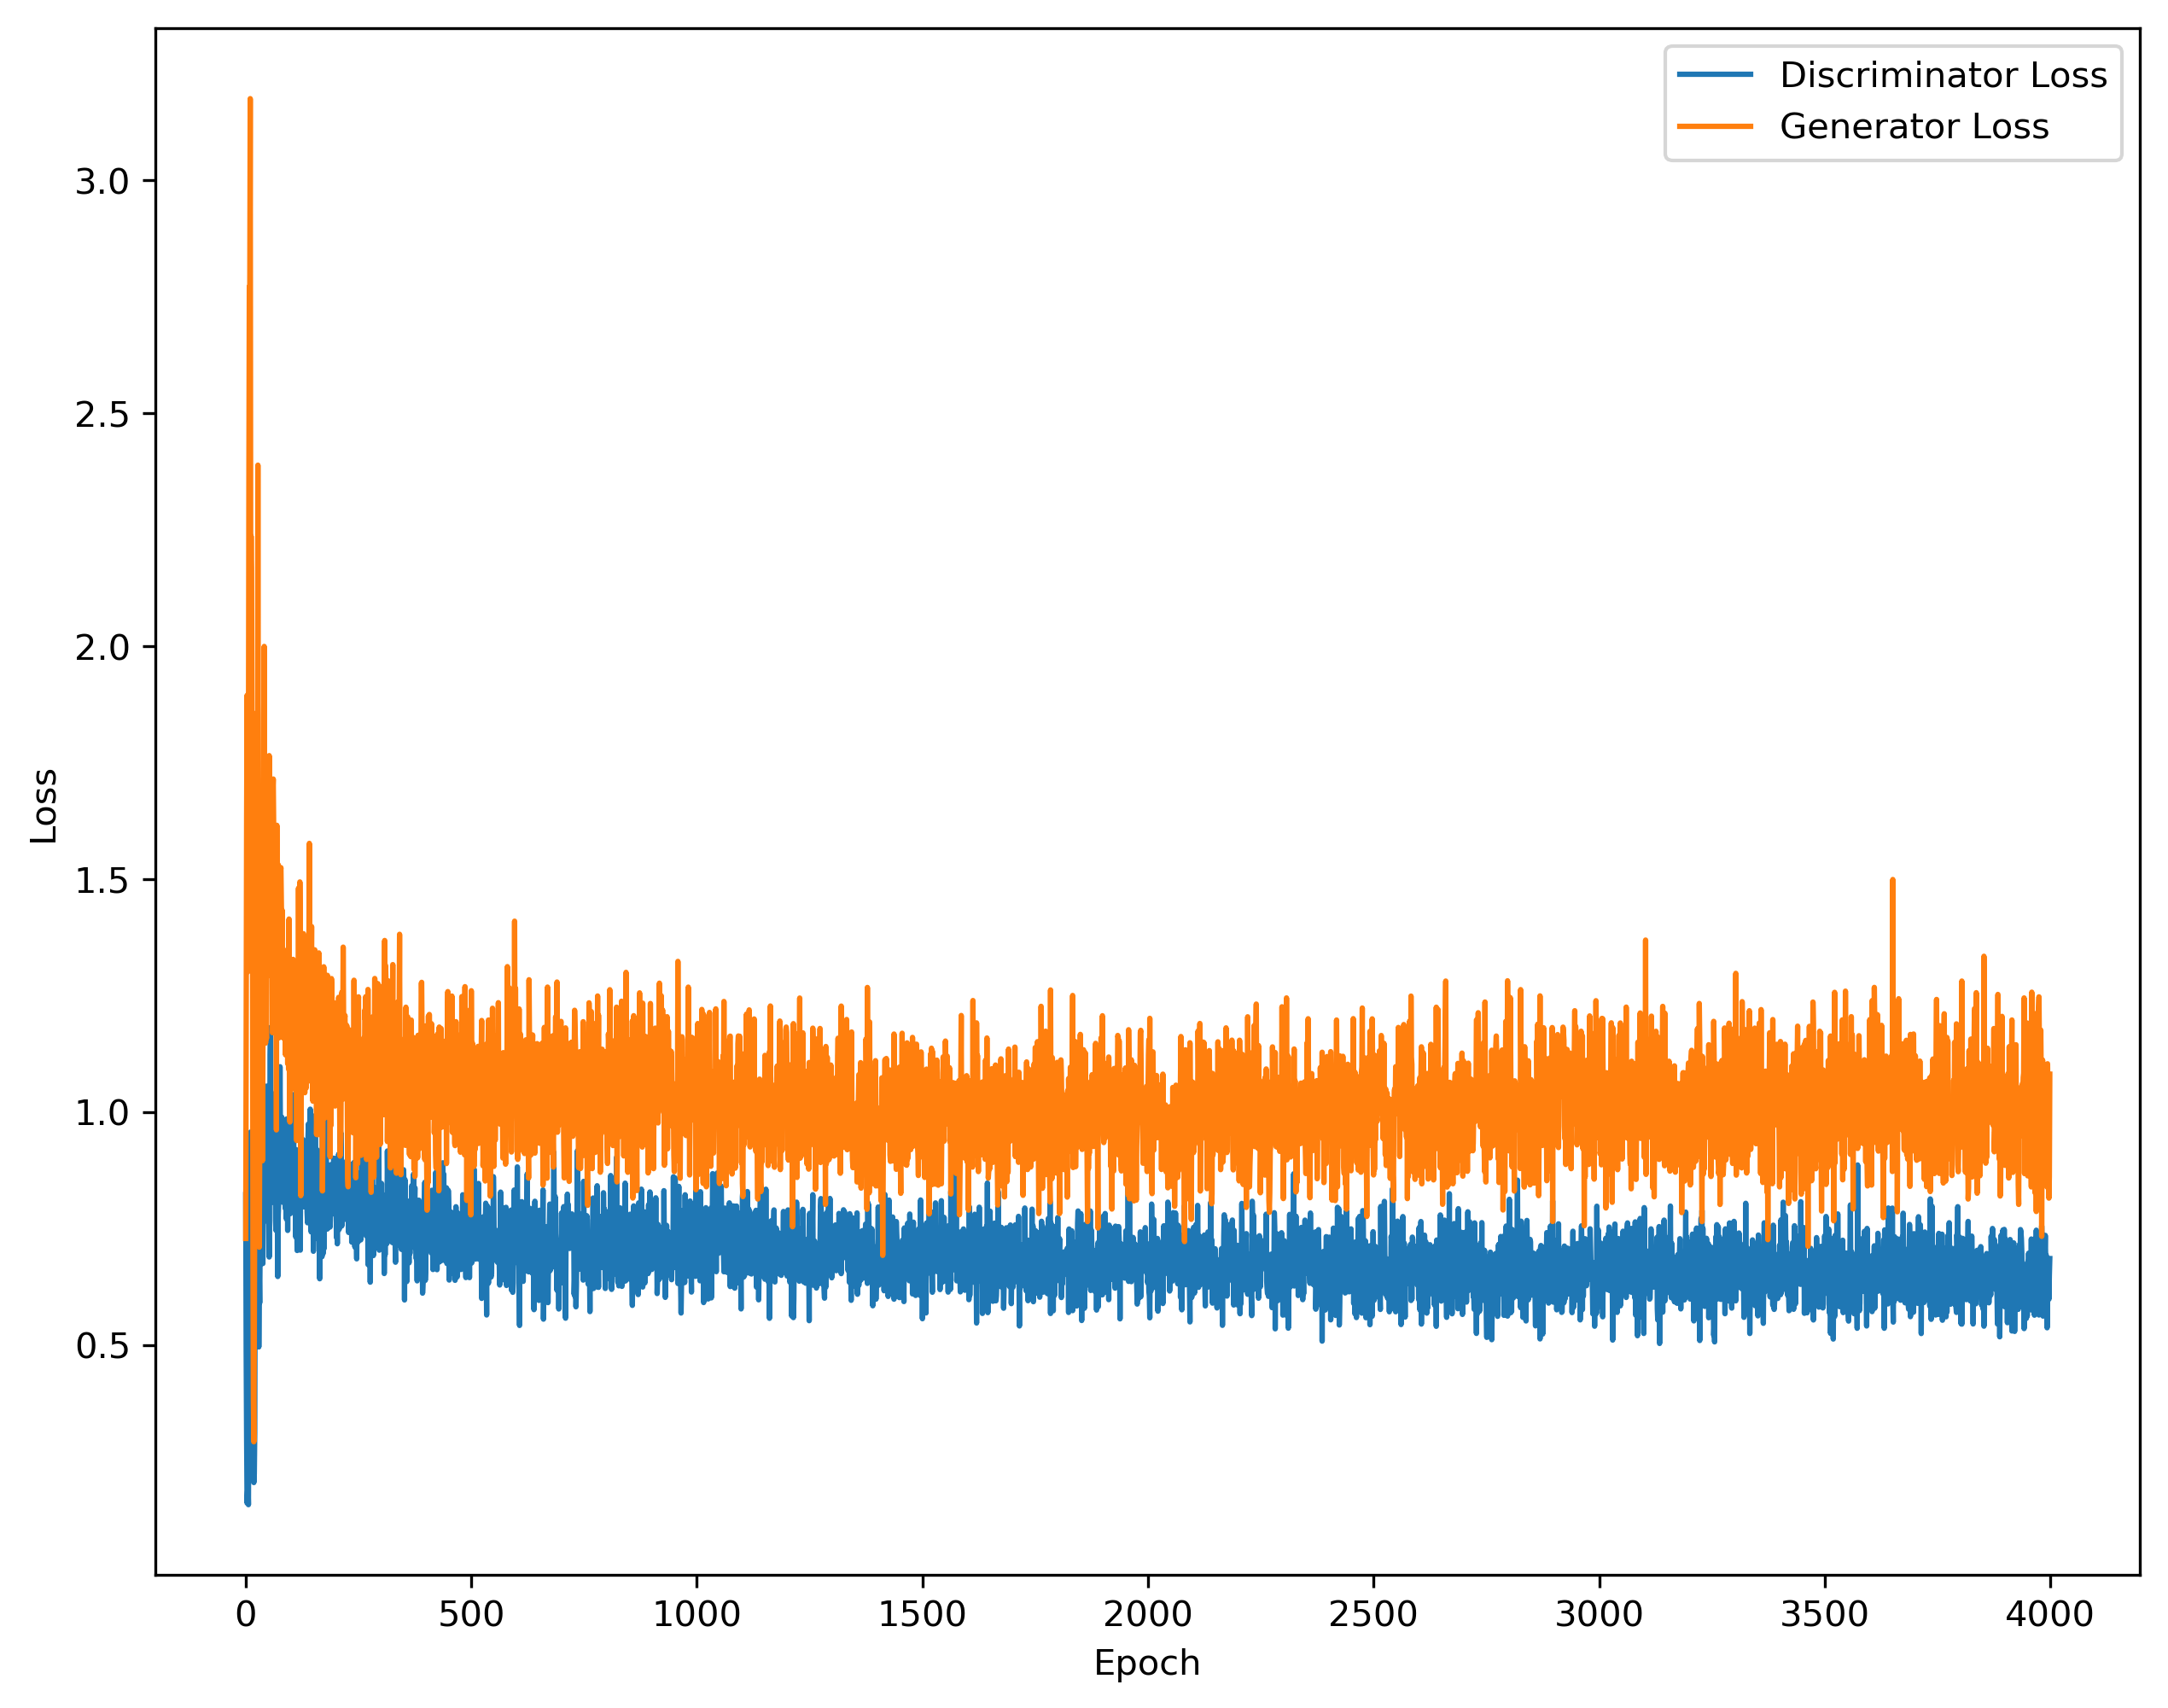

In [199]:
mnistGAN.train(x_train, 4000, 32, 50)